In [1]:
import boto3
import pandas as pd
from datetime import datetime
import numpy as np
import yaml
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.base import BaseEstimator, ClassifierMixin

from sklearn.feature_selection import RFECV

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

import lightgbm as lgb

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, classification_report

import warnings
warnings.filterwarnings("ignore")

# 0. Leitura dos Dados

In [2]:
config_classifier = yaml.safe_load(open('config_classifier.yaml', 'rb'))

In [3]:
config_classifier

{'bucket_name': 'fiap-projeto-math-refined',
 'generate_new_model': False,
 'params': {'boosting_type': 'gbdt',
  'class_weight': None,
  'colsample_bytree': 1.0,
  'importance_type': 'split',
  'learning_rate': 0.01,
  'max_depth': -1,
  'min_child_samples': 20,
  'min_child_weight': 0.001,
  'min_split_gain': 0.0,
  'n_estimators': 358,
  'n_jobs': -1,
  'num_leaves': 31,
  'objective': 'binary',
  'random_state': 42,
  'reg_alpha': 0.0,
  'reg_lambda': 0.0,
  'subsample': 1.0,
  'subsample_for_bin': 200000,
  'subsample_freq': 0},
 'path_file_name': 'bitcoin/part-00000-a456c75c-7ccc-4db5-bd30-c4d135abc456-c000.snappy.parquet',
 'run_optuna': False,
 'run_selector': False,
 'vars': ['Volume',
  'log_return_1d',
  'zscore_7',
  'rolling_std_30',
  'momentum_3d',
  'rsi_14']}

## 0.1 Extraindo Dados do S3

In [4]:
extract_table = False
if extract_table:
    client = boto3.client('s3')
    client.download_file(Bucket=config_classifier['bucket_name'], Key=config_classifier['path_file_name'], Filename='file.snappy.parquet')

In [5]:
# Carregar dados (ajuste o caminho do arquivo)
df = pd.read_parquet('file.snappy.parquet')

In [6]:
df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'target']].copy()

# 1. Processamento dos Dados

In [7]:
def generate_features(df):
    df = df.copy()
    df.sort_values("Date", inplace=True)
    df.reset_index(drop=True, inplace=True)

    # features baseadas em janelas de tempo
    df['log_return_1d'] = np.log(df['Close'] / df['Close'].shift(1))
    for win in [7, 30, 90, 180]:
        df[f'rolling_mean_{win}'] = df['Close'].rolling(win).mean()
        df[f'rolling_std_{win}'] = df['Close'].rolling(win).std()
        df[f'rolling_max_{win}'] = df['Close'].rolling(win).max()
        df[f'rolling_min_{win}'] = df['Close'].rolling(win).min()
        df[f'zscore_{win}'] = (df['Close'] - df[f'rolling_mean_{win}']) / (df[f'rolling_std_{win}'] + 1e-9)

    # features baseadas em momento de mercado
    df['momentum_3d'] = df['Close'] - df['Close'].shift(3)
    df['momentum_7d'] = df['Close'] - df['Close'].shift(7)

    # features baseadas em RSI (sugestão do chatGPT) em uma janela de 14 dias.
    #O RSI varia entre 0 e 100, e indica:
     #   RSI > 70 → ativo sobrecomprado (pode estar esticado, possível correção ou queda).
     #   RSI < 30 → ativo sobrevendido (pode estar barato, possível recuperação).
     #   RSI entre 30 e 70 → zona neutra.
    delta = df['Close'].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / (avg_loss + 1e-9)
    df['rsi_14'] = 100 - (100 / (1 + rs))

    # janela móvel do volume dos ultimos 7 dias
    df['volume_mean_7'] = df['Volume'].rolling(7).mean()

    #A variável volume_spike mede o quanto o volume negociado em um dia está acima ou abaixo da média recente — ou seja, ela identifica “picos” (spikes) ou quedas de volume.
    df['volume_spike'] = df['Volume'] / (df['volume_mean_7'] + 1e-9)

    #A variável position_in_range_30 indica onde o preço de fechamento do dia atual está localizado dentro da faixa dos últimos 30 dias.
    df['position_in_range_30'] = (df['Close'] - df['rolling_min_30']) / (df['rolling_max_30'] - df['rolling_min_30'] + 1e-9)

    # Construção da target "dia bom para entrar" (subida de 5% em até 3 dias)
    df['future_max_3d'] = df['Close'].shift(-1).rolling(3).max()
    df['target'] = (df['future_max_3d'] >= df['Close'] * 1.05).astype(int)

    # Remover colunas temporárias e dados NA
    df.drop(columns=['future_max_3d', 'volume_mean_7'], inplace=True)
    df.dropna(inplace=True)

    return df

In [8]:
# Gerar features e target
df = generate_features(df)

In [9]:
df.set_index(['Date'], inplace=True)

# 2. Separando Dados de Treino e Teste

In [10]:
# Separar features e target
X = df.drop(columns=['target'])
y = df['target']

# Divisão temporal treino/teste (80% / 20%)
train_size = int(len(df) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# 3. Seleção de variáveis

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

In [12]:
if config_classifier['run_selector']:
    # Instanciar modelo LightGBM para seleção de variáveis
    estimator = lgb.LGBMClassifier(objective='binary', random_state=42, n_jobs=-1, n_estimators=100)
    
    cv = StratifiedKFold(5)
    
    selector = RFECV(
        estimator=estimator,
        step=1,
        cv=cv,
        scoring='roc_auc',
        min_features_to_select=5,
        n_jobs=-1,
        verbose=1
    )
    selector.fit(X_train, y_train)
    
    print(f"\nNúmero ótimo de features: {selector.n_features_}")
    features_selecionadas = X_train.columns[selector.support_].to_list()

    config_classifier.update({'vars': features_selecionadas})

    with open('config_classifier.yaml', 'w') as f:
        yaml.dump(config_classifier, f)

In [13]:
features_selecionadas = config_classifier['vars']

# 4. Treinamento do modelo com as variáveis selecionadas

In [14]:
# Treinar modelo final com features selecionadas
X_train_sel = X_train[features_selecionadas]
X_test_sel = X_test[features_selecionadas]

if config_classifier['generate_new_model']:
    model_final = lgb.LGBMClassifier(objective='binary', random_state=42, n_jobs=-1, n_estimators=1000, learning_rate=0.01)
    model_final.fit(X_train_sel, y_train, eval_set=[(X_test_sel, y_test)], callbacks=[lgb.early_stopping(stopping_rounds=50)])
    n = model_final.best_iteration_
    hyper_parameters = model_final.get_params()
    hyper_parameters.update({'n_estimators':n})
    config_classifier.update({'params': hyper_parameters})
    with open('config_classifier.yaml', 'w') as f:
        yaml.dump(config_classifier, f)
else:
    params = config_classifier['params']
    model_final = lgb.LGBMClassifier(**params)
    model_final.fit(X_train_sel, y_train)

[LightGBM] [Info] Number of positive: 394, number of negative: 2570
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 2964, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.132928 -> initscore=-1.875310
[LightGBM] [Info] Start training from score -1.875310


## 4.1 Importância de variáeis

In [15]:
df_feature_imp = pd.DataFrame()
df_feature_imp['name'] = model_final.feature_names_in_
df_feature_imp['importance'] = model_final.feature_importances_
df_feature_imp['importance'] = df_feature_imp['importance']/df_feature_imp['importance'].sum()

In [16]:
df_feature_imp.sort_values(['importance'], ascending=False)

,name,importance
3,rolling_std_30,0.193669
0,Volume,0.181285
1,log_return_1d,0.175885
5,rsi_14,0.171881
2,zscore_7,0.138641
4,momentum_3d,0.138641


# 5. Avaliando resultados do modelo

In [17]:
X_train['base'] = 'treino'
X_test['base'] = 'teste'

In [18]:
df_all = pd.concat([X_train, X_test])
df_all.reset_index(inplace=True)

In [19]:
df_all['Date'] = pd.to_datetime(df_all['Date'], format='%Y-%m-%d %H:%M:%S')
df_all['ano'] = df_all['Date'].dt.year

In [20]:
df_all.groupby(['base']).agg({'Date':['max', 'min']})

Date           
              max        min
base                        
teste  2025-05-05 2023-04-26
treino 2023-04-25 2015-03-15

In [21]:
y.reset_index(inplace=True, drop=True)

In [22]:
# Avaliação treino
y_pred_train = model_final.predict(X_train_sel)
y_prob_train = model_final.predict_proba(X_train_sel)[:, 1]

In [23]:
# Avaliação final
y_pred = model_final.predict(X_test_sel)
y_prob = model_final.predict_proba(X_test_sel)[:, 1]

In [24]:
# Criando variáveis de resultados e target
df_all['target'] = y
df_all['score'] = np.concatenate([y_prob_train, y_prob])
df_all['pred'] = np.concatenate([y_pred_train, y_pred])
df_all.dropna(inplace=True)

## 5.1 Matriz de Confusão (Precision, recall e F1-Score)

In [25]:
print(f"\nAUC no teste: {roc_auc_score(y_test, y_prob):.4f}")
print(classification_report(y_test, y_pred))


AUC no teste: 0.7850
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       692
           1       1.00      0.49      0.66        49

    accuracy                           0.97       741
   macro avg       0.98      0.74      0.82       741
weighted avg       0.97      0.97      0.96       741



## 5.2 AUC ao longo do tempo

In [26]:
auc_ano = []
for ano in df_all['ano'].unique():
    df_aux = df_all[df_all['ano']==ano]
    auc_ano.append(roc_auc_score(df_aux['target'], df_aux['score']))

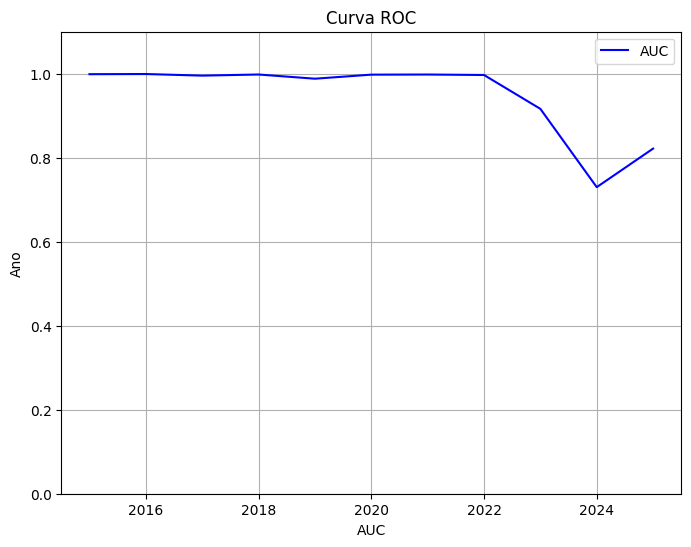

In [27]:
# Plot da curva ROC
plt.figure(figsize=(8, 6))
plt.plot(df_all['ano'].unique(), auc_ano, color='blue', label=f"AUC")
# plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Linha de referência
plt.ylim((0, 1.1))
plt.xlabel("AUC")
plt.ylabel("Ano")
plt.title("Curva ROC")
plt.legend()
plt.grid(True)
plt.show()

## 5.3 Precision e Recall ao longo do tempo

In [28]:
precision_ano = []
recall_ano = []
for ano in df_all['ano'].unique():
    df_aux = df_all[df_all['ano']==ano]
    precision_ano.append(precision_score(df_aux['target'], df_aux['pred']))
    recall_ano.append(recall_score(df_aux['target'], df_aux['pred']))

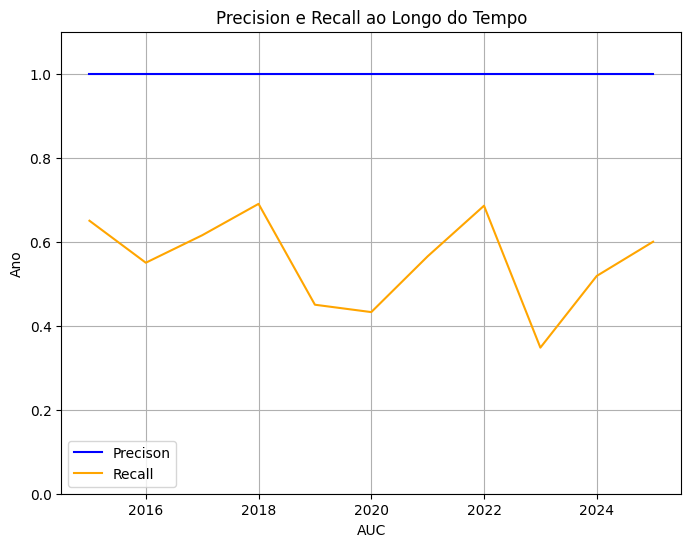

In [29]:
# Plot da curva ROC
plt.figure(figsize=(8, 6))
plt.plot(df_all['ano'].unique(), precision_ano, color='blue', label=f"Precison")
plt.plot(df_all['ano'].unique(), recall_ano, color='orange', label=f"Recall")
# plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Linha de referência
plt.ylim((0, 1.1))
plt.xlabel("AUC")
plt.ylabel("Ano")
plt.title("Precision e Recall ao Longo do Tempo")
plt.legend()
plt.grid(True)
plt.show()

## 5.4 Ajuste do Score

### 5.4.1 validação

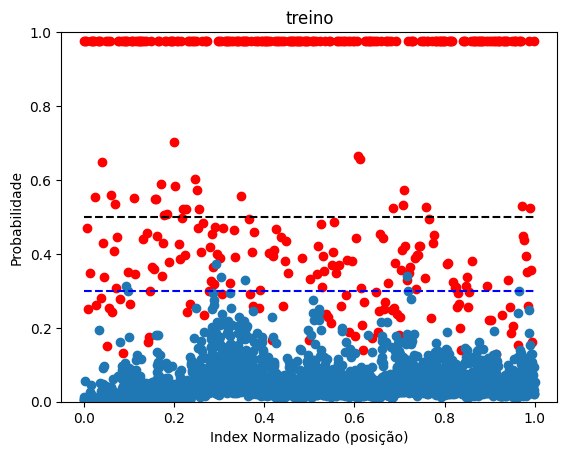

In [30]:
ds_plot = df_all[(df_all['target']!=1) & (df_all['base']=='treino')].copy()
ds_plot_subiu = df_all[(df_all['target']==1) & (df_all['base']=='treino')]
plt.title('treino')

plt.scatter(x=np.arange(0, 1, 1/(ds_plot_subiu.shape[0]))[:-1], y=ds_plot_subiu['score'], color='r')

plt.scatter(x=np.arange(0, 1, 1/ds_plot.shape[0]), y=ds_plot['score'])



plt.xlabel("Index Normalizado (posição)")
plt.ylabel("Probabilidade")


plt.plot([0,1],[0.5,0.5],'--',color="black")
plt.plot([0,1],[0.3,0.3],'--',color="blue")


plt.ylim((0,1))
plt.show()

### 5.4.2 Teste

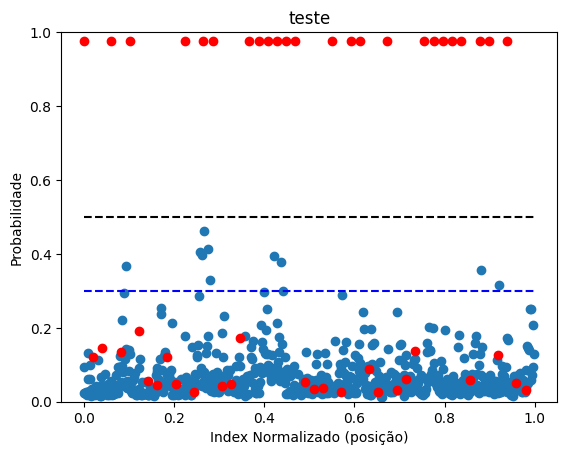

In [31]:
ds_plot = df_all[(df_all['target']!=1) & (df_all['base']=='teste')].copy()
ds_plot_subiu = df_all[(df_all['target']==1) & (df_all['base']=='teste')]
plt.title('teste')

plt.scatter(x=np.arange(0, 1, 1/ds_plot.shape[0]), y=ds_plot['score'])
plt.scatter(x=np.arange(0, 1, 1/ds_plot_subiu.shape[0])[:-1], y=ds_plot_subiu['score'], color='r')

plt.xlabel("Index Normalizado (posição)")
plt.ylabel("Probabilidade")

plt.plot([0,1],[0.5,0.5],'--',color="black")
plt.plot([0,1],[0.3,0.3],'--',color="blue")

plt.ylim((0,1))

plt.show()

### 5.4.3 avaliação dos resultados

#### Maior Risco

In [32]:
df_all.loc[(df_all['score']>=0.3), 'new_pred'] = 1
df_all['new_pred'].fillna(0, inplace=True)

In [33]:
precision_ano = []
recall_ano = []
for ano in df_all['ano'].unique():
    df_aux = df_all[(df_all['ano']==ano)]
    precision_ano.append(precision_score(df_aux['target'], df_aux['new_pred']))
    recall_ano.append(recall_score(df_aux['target'], df_aux['new_pred']))

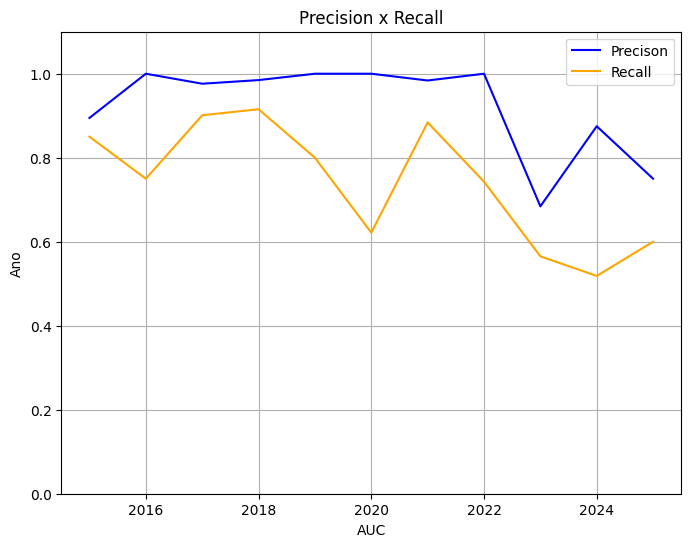

In [34]:
# Plot da curva ROC
plt.figure(figsize=(8, 6))
plt.plot(df_all['ano'].unique(), precision_ano, color='blue', label=f"Precison")
plt.plot(df_all['ano'].unique(), recall_ano, color='orange', label=f"Recall")
# plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Linha de referência
plt.ylim((0, 1.1))
plt.xlabel("AUC")
plt.ylabel("Ano")
plt.title("Precision x Recall")
plt.legend()
plt.grid(True)
plt.show()

- Das vezes que o modelo indica que o preço da moeda irá subir, ele acertou 75%, representando 60% do total.

#### Menor Risco

In [35]:
df_all.loc[(df_all['score']>=0.5), 'new_pred_n_risk'] = 1
df_all['new_pred_n_risk'].fillna(0, inplace=True)

In [36]:
precision_ano = []
recall_ano = []
for ano in df_all['ano'].unique():
    df_aux = df_all[(df_all['ano']==ano)]
    precision_ano.append(precision_score(df_aux['target'], df_aux['new_pred_n_risk']))
    recall_ano.append(recall_score(df_aux['target'], df_aux['new_pred_n_risk']))

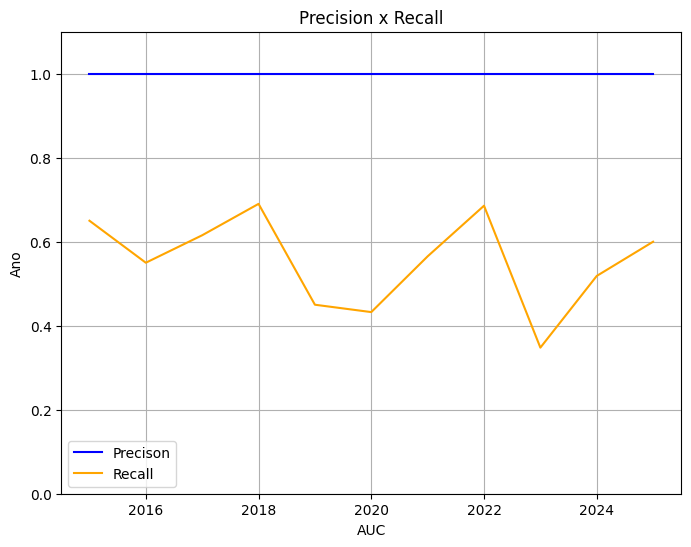

In [37]:
# Plot da curva ROC
plt.figure(figsize=(8, 6))
plt.plot(df_all['ano'].unique(), precision_ano, color='blue', label=f"Precison")
plt.plot(df_all['ano'].unique(), recall_ano, color='orange', label=f"Recall")
# plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Linha de referência
plt.ylim((0, 1.1))
plt.xlabel("AUC")
plt.ylabel("Ano")
plt.title("Precision x Recall")
plt.legend()
plt.grid(True)
plt.show()

- Das vezes que o modelo indica que o preço da moeda irá subir, ele acertou 100%, representando 60% do total.